# Image generation with Variational Autoencoders (VAE)

Variational autoencoders (VAE) are powerful models for data generation. Even though their outputs are often not as good as those of GANs and diffusion models, they have the big advantage of being relatively easy to both implement and train.  

An excellent reading to better understand VAEs is the ["Tutorial on Variational Autoencoders"](https://arxiv.org/abs/1606.05908) by Carl Doersch.

Like plains autoencoders, VAEs are made of two main components: an encoder $E$ and a decoder $D$.

Unlike plain autoencoders, the encoder does not simply output a vector of latent features $z$ the input $x$, but it outputs a distribution $p(z|x)$ from which $z$ is drawn. In practice such a distribution is supposed to be Gaussian, and the encoder outputs its mean $\mu(x)$ and the covariance matrix $\Sigma(x)$.

The decoder computes the output $y$ from the latent variables $z$. At test time we won't have any input, and we will generate new data by applying the decoder to latent features $z$ drawn from a standard Gaussian distribution with zero mean and unitary variance.

Summarizing, during training the process is:

$x \xrightarrow E \mu, \Sigma \xrightarrow{\text{sample}} z \xrightarrow{D} y$,

and during generation is:

$0, I \xrightarrow{\text{sample}} z \xrightarrow{D} y$,

where $0, I$ are the mean and the covariance of the standard Gaussian distribution.

In this exercise we will use VAE to generate images of faces.

## Setup and Data

We will use pytorch ad deep learning framework. As training data we will use a subset of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

Images have been reduced to $96 \times 128$ pixels, and divided in training and validation (which we won't use). Each folder is divided in subfolders representing attributes of the faces: we will need them in the final part of the exercise.

We start by importing all the modules we are going to use, and by copying the data.

In [1]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import google.colab
import zipfile

zip_file_path ="/content/drive/MyDrive/Colab Notebooks/celebasmall.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/celebasmall")

print("Extraction complete.")


Extraction complete.


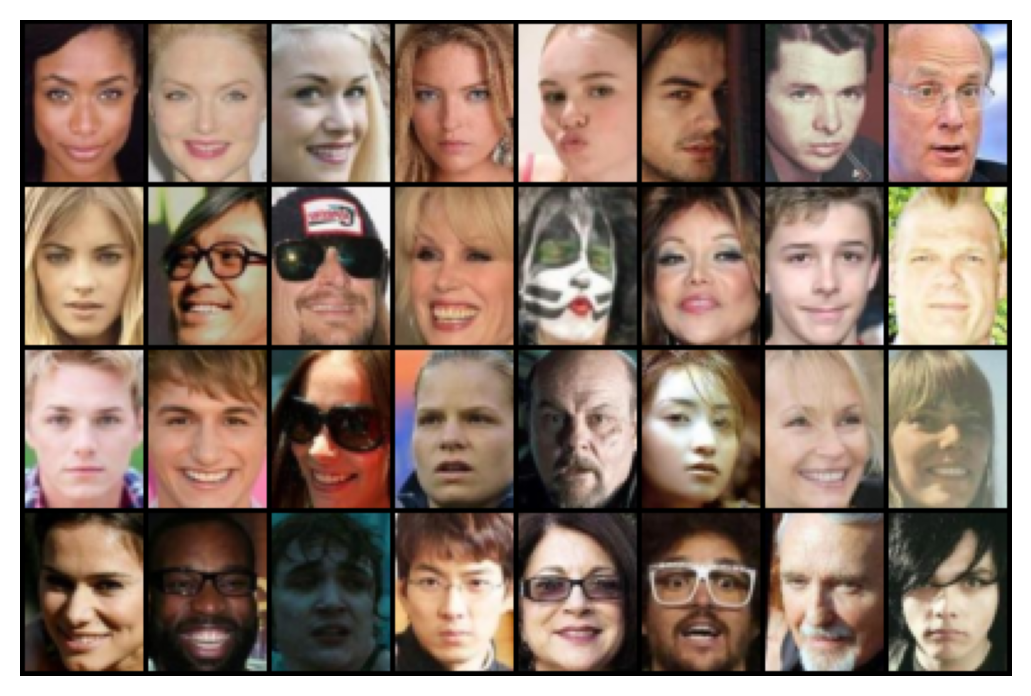

In [4]:
height = 64
width = 48

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((height, width)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the dataset
train_set = torchvision.datasets.ImageFolder(root="/content/celebasmall", transform=transform)

# Define the data loader
loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

# Function to display a grid of faces
def show_faces(faces):
    plt.rcParams['figure.dpi'] = 200
    g = torchvision.utils.make_grid(faces, normalize=True, value_range=(-1, 1))
    plt.imshow(g.permute(1, 2, 0).detach().cpu().numpy())
    plt.axis("off")
    plt.show()

# Get a batch of images and display
batch, labels = next(iter(loader))
show_faces(batch)

## Models

The autoencoder includes two main modules:
1. the Encoder;
2. the Decoder.

They will be symmetrical convolution networks.

Notes:
* instance normalization vs. batch normalization.

In [8]:

class Encoder(nn.Module):
    def __init__(self, height, width, latent_features):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * (height // 8) * (width // 8), latent_features)
        self.fc_log_var = nn.Linear(128 * (height // 8) * (width // 8), latent_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

latent = 64
encoder = Encoder(height, width, latent)
x = torch.zeros(1, 3, height, width)
mu, log_var = encoder(x)
print(mu.size(), log_var.size())
print(sum(p.numel() for p in encoder.parameters()), "parameters")


torch.Size([1, 64]) torch.Size([1, 64])
952160 parameters


In [9]:


class Decoder(nn.Module):
    def __init__(self, height, width, latent_features):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_features, 128 * (height // 8) * (width // 8))
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 128, (height // 8), (width // 8))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))  # Use tanh to get output in range [-1, 1]
        return x

latent = 64
decoder = Decoder(height, width, latent)
x = torch.zeros(1, latent)
y = decoder(x)
print(y.size())
print(sum(p.numel() for p in decoder.parameters()), "parameters")


torch.Size([1, 3, 64, 48])
564835 parameters


## Training

The loss function for the VAE model is the Evidence Lower BOund.

$\text{ELBO} = E_q[\log q(z|x) - \log p(z)] - E_q[\log p(x|z)]$

The first term is the KL divergence between $q(z|x)$ and $p(z)$.
When the two distributions are Gaussian it is (see https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Examples):

$E_q[\log q(z|x) - \log p(z)] = D_{KL}(q\|p) = \frac{1}{2}(\text{trace}(\Sigma) + \| \mu \|^2 - \log \det \Sigma)$

The second term is the expected reconstruction error.  When $p(x|z)$ is Gaussian:

$-E_q[\log p(x|z)] = E_q[\frac{1}{2\sigma^2} \| x - \text{decoder}(z) \|^2] + \text{some constant}$

The KL divergence acts as a regularizer, ensuring that the distribution of latent variables is close to the Gaussian distribution of the prior.
The reconstruction error measures how well the input data has been reconstructed. The two terms are linearly combined. The $\frac{1}{\sigma^2}$ coefficients modulates the two terms. Note that VAE may work well even with different kind of errors, like the Mean Absolute Error (MAE).


In [11]:
import torch
import os

# Define the project directory
PROJECT_DIR = "/content/celebasmall/"

# ELBO Loss function
def elbo_loss(target, generated, mu, log_var, lambda_=1e-4):
    rec_error = (generated - target).abs().mean()
    kl_div = 0.5 * (torch.exp(log_var).sum() + (mu ** 2).sum() - log_var.sum())
    loss = rec_error + lambda_ * kl_div
    return loss

# Save model function
def save_model(filename):
    data = {
        "encoder": encoder.state_dict(),
        "decoder": decoder.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    filepath = os.path.join(PROJECT_DIR, filename)
    torch.save(data, filepath)
    print(f"Model saved to {filepath}")

# Load model function
def load_model(filename):
    filepath = os.path.join(PROJECT_DIR, filename)
    data = torch.load(filepath)
    encoder.load_state_dict(data["encoder"])
    decoder.load_state_dict(data["decoder"])
    optimizer.load_state_dict(data["optimizer"])
    print(f"Model loaded from {filepath}")



In [12]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)
print(device)

cuda


In [13]:
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, 1e-3)

In [18]:
# Assuming encoder and decoder classes are defined as per previous messages
class Encoder(nn.Module):
    def __init__(self, height, width, latent_features):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * (height // 8) * (width // 8), latent_features)
        self.fc_log_var = nn.Linear(128 * (height // 8) * (width // 8), latent_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
class Decoder(nn.Module):
    def __init__(self, height, width, latent_features):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_features, 128 * (height // 8) * (width // 8))
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 128, (height // 8), (width // 8))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))  # Use tanh to get output in range [-1, 1]
        return x

# Instantiate encoder, decoder, and optimizer
latent = 64
encoder = Encoder(height, width, latent)
decoder = Decoder(height, width, latent)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)
print(device)

# Training loop
EPOCHS = 100
LAMBDA = 1e-4

for epoch in range(EPOCHS):
    total_loss = 0
    for batch, _ in loader:
        batch = batch.to(device)

        # Forward pass through encoder
        mu, log_var = encoder(batch)

        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # Forward pass through decoder
        generated = decoder(z)

        # Compute loss
        loss = elbo_loss(batch, generated, mu, log_var, lambda_=LAMBDA)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_model(f"vae_model_epoch_{epoch+1}.pth")

print("Training complete.")

cuda
Epoch [1/100], Loss: 0.4600
Epoch [2/100], Loss: 0.3901
Epoch [3/100], Loss: 0.3748
Epoch [4/100], Loss: 0.3605
Epoch [5/100], Loss: 0.3542
Epoch [6/100], Loss: 0.3491
Epoch [7/100], Loss: 0.3473
Epoch [8/100], Loss: 0.3453
Epoch [9/100], Loss: 0.3443
Epoch [10/100], Loss: 0.3432
Model saved to /content/celebasmall/vae_model_epoch_10.pth
Epoch [11/100], Loss: 0.3422
Epoch [12/100], Loss: 0.3415
Epoch [13/100], Loss: 0.3402
Epoch [14/100], Loss: 0.3401
Epoch [15/100], Loss: 0.3397
Epoch [16/100], Loss: 0.3378
Epoch [17/100], Loss: 0.3379
Epoch [18/100], Loss: 0.3377
Epoch [19/100], Loss: 0.3371
Epoch [20/100], Loss: 0.3370
Model saved to /content/celebasmall/vae_model_epoch_20.pth
Epoch [21/100], Loss: 0.3365
Epoch [22/100], Loss: 0.3367
Epoch [23/100], Loss: 0.3350
Epoch [24/100], Loss: 0.3352
Epoch [25/100], Loss: 0.3354
Epoch [26/100], Loss: 0.3343
Epoch [27/100], Loss: 0.3345
Epoch [28/100], Loss: 0.3346
Epoch [29/100], Loss: 0.3338
Epoch [30/100], Loss: 0.3338
Model saved to /

In [15]:
save_model("vae.pt")

Model saved to /content/celebasmall/vae.pt


## Generation

To generate new data, sample a new batch of latent variables from a standard Gaussian. Then, feed them into the decoder.

In [19]:
load_model("/content/celebasmall/vae_model_epoch_100.pth")

Model loaded from /content/celebasmall/vae_model_epoch_100.pth


In [23]:
# Load the trained model
load_model('vae_model_epoch_100.pth')

# Generate new data
def generate_new_data(decoder, num_samples, latent_dim, device):
    decoder.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = decoder(z)
        return generated

# Number of new samples to generate
num_samples = 16
generated_data = generate_new_data(decoder, num_samples, latent, device)

# Display generated images
show_faces(generated_data)

Model loaded from /content/celebasmall/vae_model_epoch_100.pth


## Interpolation

When the latent space is good, you can take two latent vectors, interpolate them, and obtain a smooth transition between the two faces.

In [ ]:
x0 = train_set[300][0][None].to(device)
x1 = train_set[200][0][None].to(device)


z = ...
y = decoder(z)
show_faces(y)

In [25]:
# Load the trained model
load_model('vae_model_epoch_100.pth')

# Interpolation function
def interpolate(z1, z2, num_steps):
    ratios = torch.linspace(0, 1, steps=num_steps)
    z_interpolated = [(1 - r) * z1 + r * z2 for r in ratios]
    return torch.stack(z_interpolated)

# Generate new data by interpolation
def generate_interpolated_data(decoder, z1, z2, num_steps, device):
    decoder.eval()
    with torch.no_grad():
        z_interpolated = interpolate(z1, z2, num_steps).to(device)
        generated = decoder(z_interpolated)
        return generated

# Define two random latent vectors
z1 = torch.randn(1, latent, device=device)
z2 = torch.randn(1, latent, device=device)

# Number of steps for interpolation
num_steps = 16

# Generate interpolated data
generated_data = generate_interpolated_data(decoder, z1, z2, num_steps, device)

# Display interpolated images
show_faces(generated_data)

Model loaded from /content/celebasmall/vae_model_epoch_100.pth


In [27]:
# Instantiate encoder, decoder, and optimizer
latent = 64
encoder = Encoder(height, width, latent)
decoder = Decoder(height, width, latent)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)
print(device)

# Load the trained model
load_model('vae_model_epoch_100.pth')

# Select specific images from the dataset
x0 = train_set[300][0][None].to(device)
x1 = train_set[200][0][None].to(device)

# Encode the images to obtain their latent vectors
encoder.eval()
with torch.no_grad():
    mu0, log_var0 = encoder(x0)
    mu1, log_var1 = encoder(x1)

# Use the mean (mu) as the latent representation
z0 = mu0
z1 = mu1

# Interpolation function
def interpolate(z1, z2, num_steps):
    ratios = torch.linspace(0, 1, steps=num_steps)
    z_interpolated = [(1 - r) * z1 + r * z2 for r in ratios]
    return torch.stack(z_interpolated)

# Generate new data by interpolation
def generate_interpolated_data(decoder, z1, z2, num_steps, device):
    decoder.eval()
    with torch.no_grad():
        z_interpolated = interpolate(z1, z2, num_steps).to(device)
        generated = decoder(z_interpolated)
        return generated

# Number of steps for interpolation
num_steps = 16

# Generate interpolated data
generated_data = generate_interpolated_data(decoder, z0, z1, num_steps, device)

# Display interpolated images
show_faces(generated_data)


cuda
Model loaded from /content/celebasmall/vae_model_epoch_100.pth


## Questions

In the report, answer to the following questions:
* What happens if you change the value of the parameter LAMBDA?
* What happens if you change the size of the latent space?
* What happens when $z$ is close to the center of the latent space? And when is far away from the center?

Training with LAMBDA = 1e-05
Epoch [1/10], Loss: 0.3630
Epoch [2/10], Loss: 0.2462
Epoch [3/10], Loss: 0.2179
Epoch [4/10], Loss: 0.2028
Epoch [5/10], Loss: 0.1932
Epoch [6/10], Loss: 0.1857
Epoch [7/10], Loss: 0.1807
Epoch [8/10], Loss: 0.1778
Epoch [9/10], Loss: 0.1734
Epoch [10/10], Loss: 0.1716
Generating images close to the center of the latent space


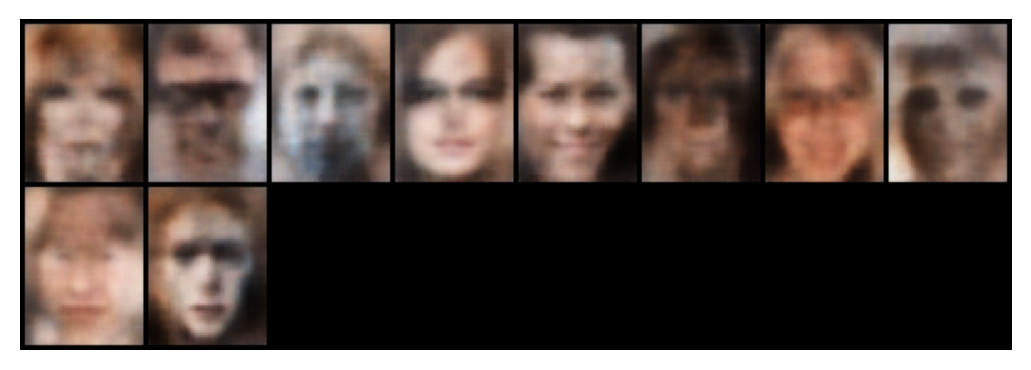

Generating images far from the center of the latent space


Training with LAMBDA = 1e-07
Epoch [1/10], Loss: 0.1271
Epoch [2/10], Loss: 0.1212
Epoch [3/10], Loss: 0.1176
Epoch [4/10], Loss: 0.1155
Epoch [5/10], Loss: 0.1129
Epoch [6/10], Loss: 0.1111
Epoch [7/10], Loss: 0.1095
Epoch [8/10], Loss: 0.1088
Epoch [9/10], Loss: 0.1082
Epoch [10/10], Loss: 0.1064
Generating images close to the center of the latent space


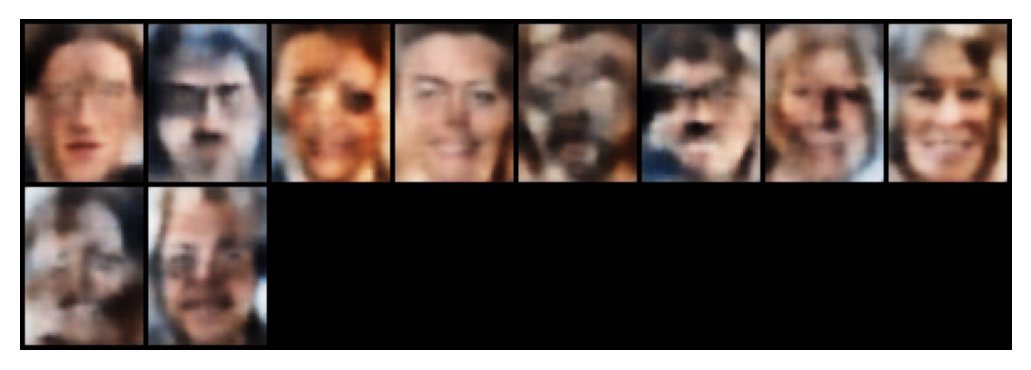

Generating images far from the center of the latent space


Training with LAMBDA = 1e-09
Epoch [1/10], Loss: 0.1053
Epoch [2/10], Loss: 0.1048
Epoch [3/10], Loss: 0.1036
Epoch [4/10], Loss: 0.1028
Epoch [5/10], Loss: 0.1023
Epoch [6/10], Loss: 0.1019
Epoch [7/10], Loss: 0.1017
Epoch [8/10], Loss: 0.1020
Epoch [9/10], Loss: 0.1010
Epoch [10/10], Loss: 0.1006
Generating images close to the center of the latent space


Generating images far from the center of the latent space


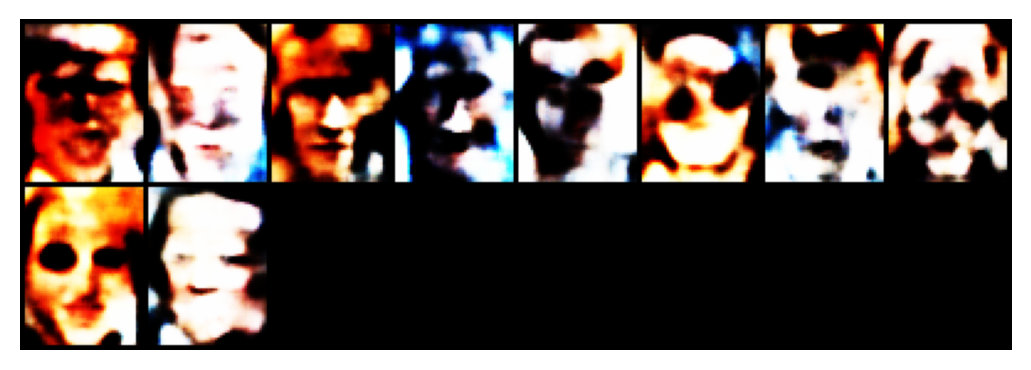

In [29]:

# ELBO Loss function
def elbo_loss(target, generated, mu, log_var, lambda_=1e-4):
    rec_error = (generated - target).abs().mean()
    kl_div = 0.5 * (torch.exp(log_var).sum() + (mu ** 2).sum() - log_var.sum())
    loss = rec_error + lambda_ * kl_div
    return loss

# Encoder and Decoder classes (definitions omitted for brevity)

def train_vae(encoder, decoder, optimizer, loader, epochs, lambda_):
    encoder.train()
    decoder.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch, _ in loader:
            batch = batch.to(device)
            mu, log_var = encoder(batch)
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            z = mu + eps * std
            generated = decoder(z)
            loss = elbo_loss(batch, generated, mu, log_var, lambda_)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return encoder, decoder

def generate_and_show(decoder, num_samples, latent_dim, device, close_to_center=True):
    decoder.eval()
    with torch.no_grad():
        if close_to_center:
            z = torch.randn(num_samples, latent_dim).to(device)
        else:
            z = 5 * torch.randn(num_samples, latent_dim).to(device)
        generated = decoder(z)
    show_faces(generated)

# Instantiate encoder, decoder, and optimizer
latent = 64  # Change this value to experiment with different latent space sizes
encoder = Encoder(height, width, latent)
decoder = Decoder(height, width, latent)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Load the dataset and prepare the data loader
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((height, width)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_set = torchvision.datasets.ImageFolder(root="/content/celebasmall", transform=transform)
loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

# Train the model with different LAMBDA values
lambdas = [1e-5, 1e-7, 1e-9]
epochs = 10

for lambda_ in lambdas:
    print(f"Training with LAMBDA = {lambda_}")
    encoder, decoder = train_vae(encoder, decoder, optimizer, loader, epochs, lambda_)

    # Generate and show images from latent vectors close to and far from the center
    print("Generating images close to the center of the latent space")
    generate_and_show(decoder, num_samples=10, latent_dim=latent, device=device, close_to_center=True)

    print("Generating images far from the center of the latent space")
    generate_and_show(decoder, num_samples=10, latent_dim=latent, device=device, close_to_center=False)
